### Ranking Replication
* Zweck: Replikation des Kapitel "Ranking" aus dem Paper "Predicting Vulnerable Software Components"
* Matrix: Aktueller Stand "current" des mozilla-central Repository
* Features: Includes, FUnction Calls
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set/Test-Set: Stratified sampling auf einer Matrix (2/3 : 1/3)

#### Results
Angenommen man konzentriert seine Ressourcen auf die Optimierung der 1% verwundbarsten Komponenten. Bei der Auswahl verlässt man sich auf die Vorhersage des Regressionsmodells. Dieses Skript berechnet den Faktor zwischen der Anzahl Verwundbarkeiten die in diesem Fall behoben werden und der Anzahl Verwundbarkeiten die bei der Konzentration auf 1% maximal behoben werden können.
* Resultat: Faktor zwischen behobenen und maximal behebbaren Verwundbarkeiten.

0 - f_opt: 397.0, quotient: 0.722921914358
1 - f_opt: 462.0, quotient: 0.666666666667
2 - f_opt: 427.0, quotient: 0.690866510539
3 - f_opt: 398.0, quotient: 0.618090452261
4 - f_opt: 425.0, quotient: 0.724705882353
5 - f_opt: 448.0, quotient: 0.658482142857
6 - f_opt: 410.0, quotient: 0.707317073171
7 - f_opt: 423.0, quotient: 0.713947990544
8 - f_opt: 431.0, quotient: 0.596287703016
9 - f_opt: 416.0, quotient: 0.711538461538
10 - f_opt: 390.0, quotient: 0.728205128205
11 - f_opt: 540.0, quotient: 0.757407407407
12 - f_opt: 399.0, quotient: 0.621553884712
13 - f_opt: 379.0, quotient: 0.738786279683
14 - f_opt: 404.0, quotient: 0.678217821782
15 - f_opt: 355.0, quotient: 0.735211267606
16 - f_opt: 346.0, quotient: 0.658959537572
17 - f_opt: 495.0, quotient: 0.769696969697
18 - f_opt: 452.0, quotient: 0.721238938053
19 - f_opt: 386.0, quotient: 0.69170984456
20 - f_opt: 550.0, quotient: 0.672727272727
21 - f_opt: 365.0, quotient: 0.717808219178
22 - f_opt: 431.0, quotient: 0.69837587007


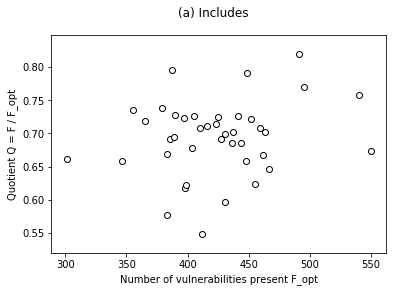

In [2]:
%matplotlib inline

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
import matplotlib.pyplot as plt
import numpy as np

matrix_helper = MatrixHelper()
experiments_count = 40

# read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_reg_incl_current.pickle')

quotient_list = []
f_opt_list = []
for i in range(experiments_count):
    # Instantiate Prediction Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='SVR')

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 1% of both matrices
    relevant_samples_count = 30 #int(round(0.01 * len(compare_matrix_sorted_predicted)))
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))
    
    f_opt_list.append(f_opt)
    quotient_list.append(f / f_opt)
    print('{} - f_opt: {}, quotient: {}'.format(i, f_opt, f / f_opt))

# plot
fig = plt.figure()
plt.scatter(f_opt_list, quotient_list, edgecolor='black', linewidth='1', facecolor='white')
fig.suptitle('(a) Includes')
plt.xlabel('Number of vulnerabilities present F_opt')
plt.ylabel('Quotient Q = F / F_opt')
fig.savefig('outputs/f_opt-quotient-includes-current.pdf')

# print
quotient_average = sum(quotient_list) / float(len(quotient_list))
print('Average Quotient of {} Experiments: {}'.format(experiments_count, quotient_average)) 